In [ ]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torchvision.models.detection as detection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [165]:
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == 'face':
        return 1
    return 0

def generate_target(image_id, file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
        
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = img_id
        return target

In [166]:
imgs = list(sorted(os.listdir("./labels/images")))
labels = list(sorted(os.listdir('./labels/ann')))

In [167]:
class AnimeDataSet(object):
    def __init__(self, transforms, imgs, labels):
        self.transforms = transforms
        self.imgs = imgs
        self.labels = labels
    
    def __getitem__(self, x):
        file_image = str(x).zfill(6) + '.jpg'
        file_label = str(x).zfill(6) + '.xml'
        img_path = os.path.join("./labels/images/", file_image)
        label_path = os.path.join("./labels/ann/", file_label)
        img = Image.open(img_path).convert('RGB')
        target = generate_target(x, label_path)
        if self.transforms is not None:
            img = self.transforms(img) #转换  
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [168]:
data_transform =transforms.Compose([transforms.ToTensor()])

In [169]:
def collate_fn(batch):
    return tuple(zip(*batch))
train_dataset = AnimeDataSet(data_transform, imgs[:2000], labels[:2000])
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
#eval_dataset = AnimeDataSet(data_transform, imgs[5000:5100], labels[5000:5100])
#eval_data_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=4, collate_fn=collate_fn)

In [71]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model = get_model_instance_segmentation(2) # 二分类问题

In [172]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    break

# Train

In [175]:
import time
num_epochs = 25
model.to(device)
t =  time.time()
# 参数
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
all_loss = pd.DataFrame(columns=['train_epoch_loss'])
for epoch in range(num_epochs):
    model.train()   
    train_epoch_loss = 0
    #eval_epoch_loss = 0
    for imgs, annotations in data_loader:
        s = time.time()
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        try:
            loss_dict = model([imgs[0]], [annotations[0]])
        except:
            continue
        losses = sum(loss for loss in loss_dict.values())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        #print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        train_epoch_loss += losses
        one_iter = time.time()-s

    '''
    for imgs, annotations in eval_data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())
        eval_epoch_loss += losses  
    '''
    print(f'epoch: {epoch}, train_loss: {train_epoch_loss}')   
    all_loss = all_loss.append({'train_epoch_loss':train_epoch_loss.item()}, ignore_index=True)  
all_time = time.time()-t 

In [63]:
def save_res(name):
    all_loss.to_csv(name+".csv",index=False)
    torch.save(model.state_dict(),name+".pt")
    with open('./results/time.txt','a+') as f:
        f.write(name+': '+str(all_time)+'\n')
save_res('resnet50')

# 验证模型

In [46]:
def plot_image(img_tensor, annotation=None, i=0, name=None):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    ax.imshow(img.permute(1, 2, 0)) 
    if annotation==None:
        plt.show()
        return
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.detach()

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    path = './results/'+name+'/'
    try:
        os.mkdir(path)
    except:
        pass
    plt.savefig(path+'pred'+str(i).zfill(5)+'.jpg')
    plt.show()
    #plt.savefig('pred'+str(i).zfill(5)+'.jpg')

In [33]:
def trans_images(trans, images):
    imgs = []
    for file_image in images:
        img_path = os.path.join("./pixiv/", file_image)
        img = Image.open(img_path).convert('RGB')
        if trans is not None:
            img = trans(img) #转换
        imgs.append(img)
    return imgs

In [59]:
def load_model(name):
    model = get_model_instance_segmentation(2)
    model.load_state_dict(torch.load(name+'.pt'))
    model.eval()
    return model
model = load_model('resnet50') 

In [ ]:
files = os.listdir("./pixiv/")
i = 0
for file in files:
    os.rename("./pixiv/"+file, "./pixiv/"+str(i).zfill(4)+'.jpg')
    i+=1
files = os.listdir("./pixiv/")
i = 0
for file in files:
    os.rename("./pixiv/"+file, "./pixiv/"+str(i).zfill(5)+'.jpg')
    i +=1

In [ ]:
def plot_train_loss(name):
    loss = pd.read_csv(name+'.csv')
    plt.plot(loss['train_epoch_loss'],label='resnet50')
    plt.legend()
    plt.savefig("./results/"+name+'.png')

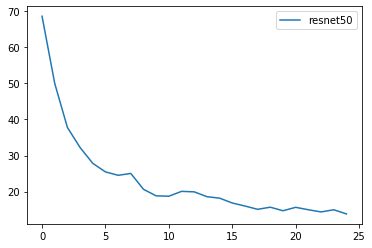

In [ ]:
plot_train_loss('resnet50')

In [ ]:
imgs = list(sorted(os.listdir("./pixiv/")))
images = trans_images(data_transform, imgs)
model.eval()
model.to('cpu')
preds = model(images)
def save_result_pic(preds, name):
   for i in range(len(preds)):
      plot_image(images[i], preds[i], i, name)
save_result_pic(preds, 'resnet50')